# Load image

In [1]:

import matplotlib.pyplot as plt
import cv2 
import numpy as np

%matplotlib inline

image_path = "./image/three_ships_horizon.JPG"
image = cv2.imread(image_path)
H, W, D = image.shape
print(H, W, D)


1200 1600 3


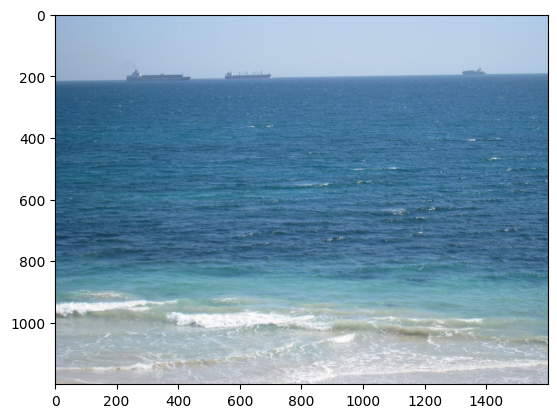

In [2]:
def cv2_imshow(cv2image):
    plt.imshow(cv2.cvtColor(cv2image, cv2.COLOR_BGR2RGB))
    plt.show()


cv2_imshow(image)

# Horizon line detection

## Segment by color

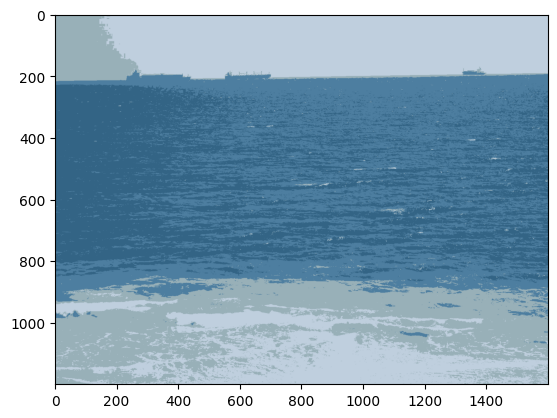

In [3]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Reshape the image to a 2D array of pixels: 1200*1600 = 1_920_000
pixel_values = image_rgb.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# Define criteria and apply k-means clustering
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 4  # Number of clusters
_, labels, centers = cv2.kmeans(
    pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS
)

centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]

segmented_image = segmented_image.reshape(image_rgb.shape)

segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
cv2_imshow(segmented_image)

## Preprocess by blur and cropping

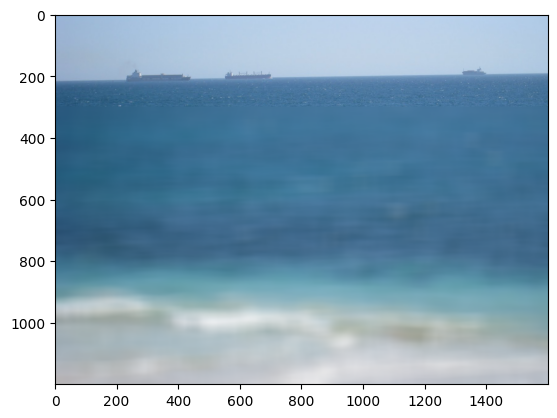

In [4]:
blur_img = image.copy()
blur_img[H // 4 : H, :] = cv2.blur(blur_img[H // 4 : H, :], (50, 50))
# blur_img[H//6*4:H, :] = cv2.blur(blur_img[H//6*4:H,:],(50,50))
# blur_img[:H//5*3, :] = cv2.blur(blur_img[:H//5*3,:],(50,50))
cv2_imshow(blur_img)

## Edge detection

In [5]:
def detect_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(
        gray, 0, 255, cv2.THRESH_TOZERO
    )  # will also produce many lines for segment even change thres to THRESH_OTSU
    edges = cv2.Canny(thresh, 50, 150, apertureSize=3)

    cv2_imshow(gray)
    cv2_imshow(thresh)
    cv2_imshow(edges)
    return edges

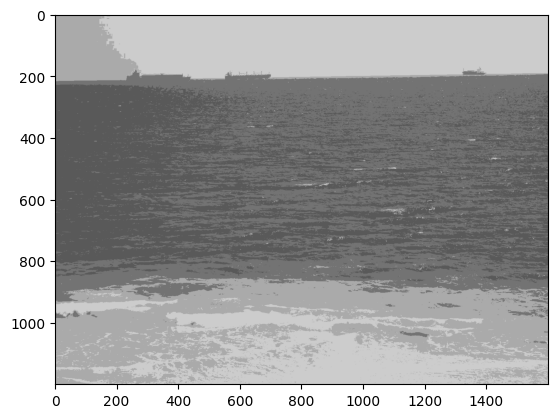

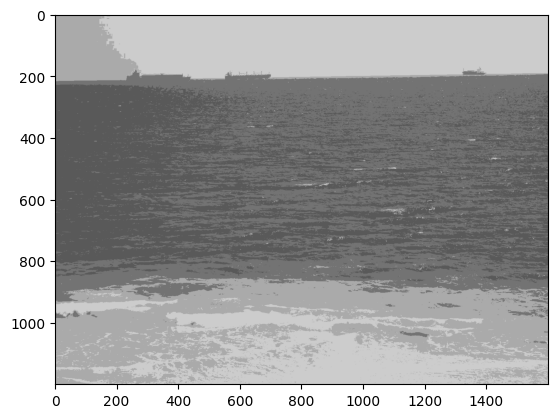

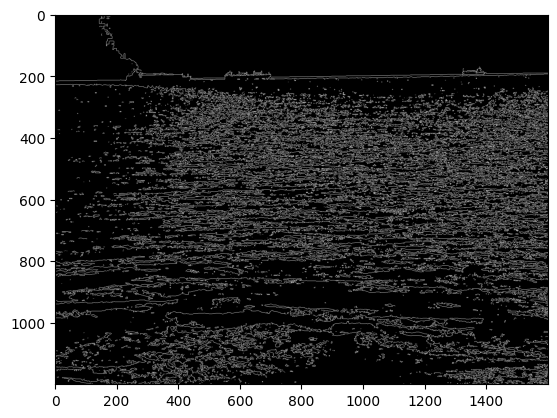

In [6]:
edge_segment_img = detect_edges(segmented_image)

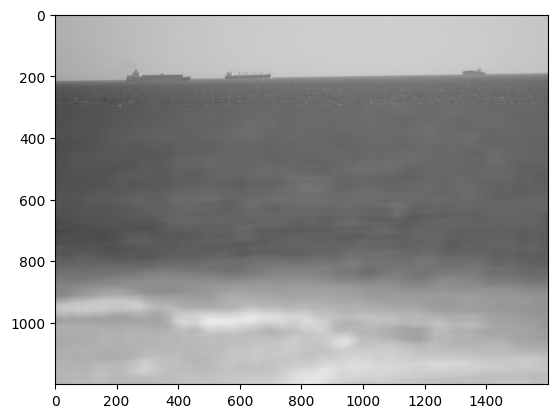

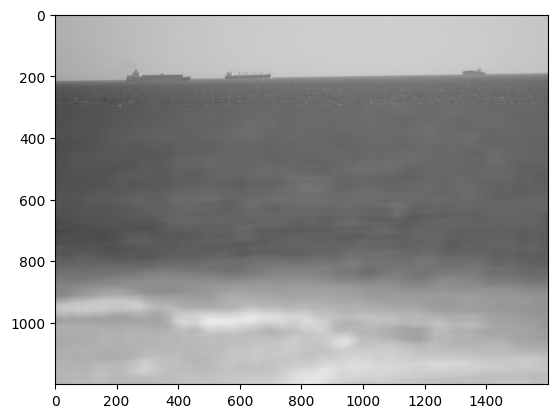

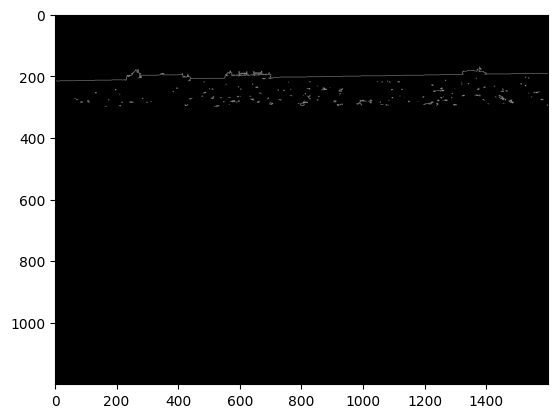

In [7]:
edge_blur_img = detect_edges(blur_img)

## HoughLines Polar

In [8]:
def detect_line(edges, W=W, H=H):
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

    print(f"Found {len(lines)} lines")

    line_draw_img = image.copy()
    line = lines[0]
    rho, theta = line[0][0], line[0][1]

    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    x0 = cos_theta * rho
    y0 = sin_theta * rho
    x1 = int(x0 + W * (-sin_theta))
    y1 = int(y0 + H * (cos_theta))
    x2 = int(x0 - W * (-sin_theta))
    y2 = int(y0 - H * (cos_theta))

    cv2.line(line_draw_img, (x1, y1), (x2, y2), (0, 255, 0), 3)
    return line_draw_img, (x1, y1), (x2, y2)

Found 8034 lines


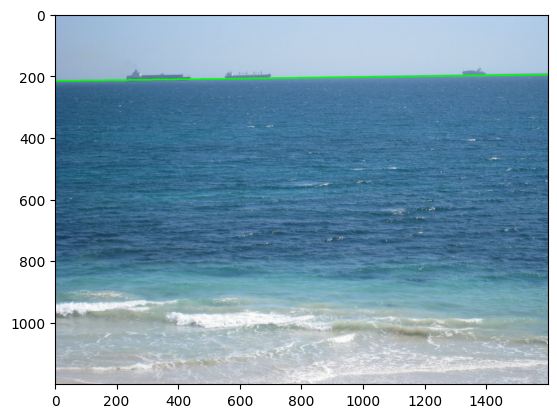

In [9]:
line_drawn_segment_img, p1, p2 = detect_line(edge_segment_img)
cv2_imshow(line_drawn_segment_img)

Found 1 lines


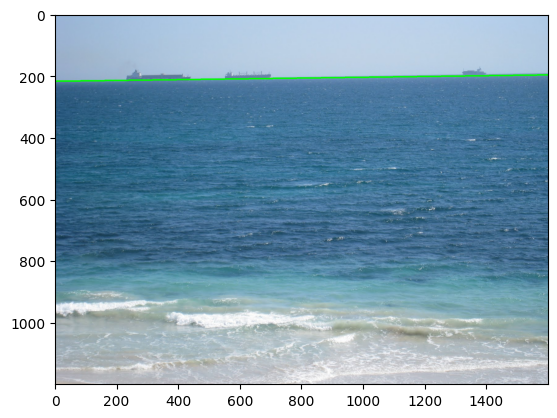

In [10]:
line_drawn_blur_img, p1, p2 = detect_line(edge_blur_img)
cv2_imshow(line_drawn_blur_img)

# Leveling horizon line

In [11]:
def level_angle(image, p1, p2):
    level_angle = np.degrees(np.arctan2(p2[1] - p1[1], p2[0] - p1[0]))

    rotate_matrix = cv2.getRotationMatrix2D(p1, angle=level_angle, scale=1)
    rotated_image = cv2.warpAffine(
        src=image, M=rotate_matrix, dsize=(image.shape[1], image.shape[0])
    )
    rotated_image_with_line = cv2.warpAffine(
        src=line_drawn_blur_img, M=rotate_matrix, dsize=(image.shape[1], image.shape[0])
    )
    return rotated_image, rotated_image_with_line

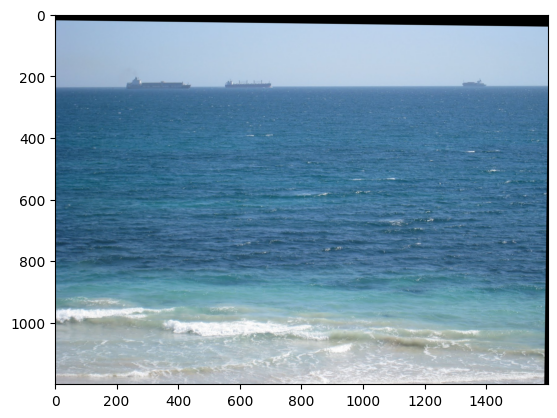

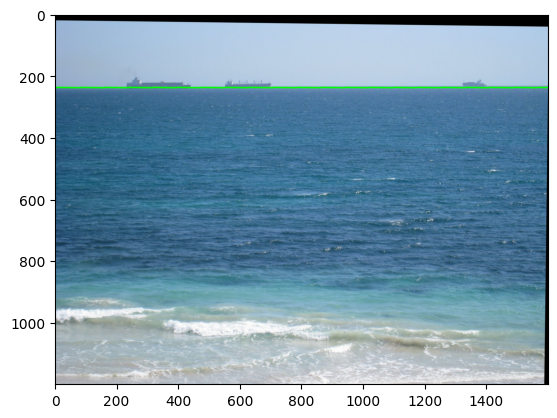

In [12]:
rotated_image, rotated_image_with_line = level_angle(image, p1, p2)
cv2_imshow(rotated_image)
cv2_imshow(rotated_image_with_line)

# Crop black boundary

72


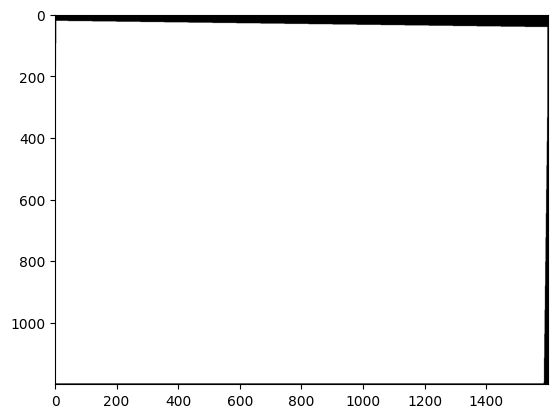

(array([   2,    2,    1,    1,    0,    0, 1587, 1587, 1588, 1588, 1589,
        1589, 1590, 1590, 1591, 1591, 1592, 1592, 1593, 1593, 1594, 1594,
        1595, 1595, 1596, 1596, 1597, 1597, 1598, 1598, 1599, 1599, 1526,
        1525, 1448, 1447, 1370, 1369, 1292, 1291, 1214, 1213, 1136, 1135,
        1058, 1057,  980,  979,  902,  901,  824,  823,  746,  745,  668,
         667,  590,  589,  512,  511,  434,  433,  356,  355,  278,  277,
         200,  199,  122,  121,   44,   43], dtype=int32),
 array([  20,   93,   94,  171,  172, 1199, 1199, 1194, 1193, 1116, 1115,
        1038, 1037,  960,  959,  882,  881,  804,  803,  726,  725,  648,
         647,  570,  569,  492,  491,  414,  413,  336,  335,   40,   40,
          39,   39,   38,   38,   37,   37,   36,   36,   35,   35,   34,
          34,   33,   33,   32,   32,   31,   31,   30,   30,   29,   29,
          28,   28,   27,   27,   26,   26,   25,   25,   24,   24,   23,
          23,   22,   22,   21,   21,   20], dtype=in

In [13]:
grayscale = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY)
ret, thresholded = cv2.threshold(grayscale, 0, 255, 0)

bbox = cv2.boundingRect(thresholded)
x, y, w, h = bbox
contours, hier = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours[0]))

for k, _ in enumerate(contours):
    im = cv2.cvtColor(
        cv2.drawContours(thresholded, contours, k, (0, 0, 255), 2), cv2.COLOR_BGR2RGB
    )

cv2_imshow(im)
x, y = contours[0].T[0][0], contours[0].T[1][0]
x, y

In [14]:
def find_contours_boundary(x, y, mode=np.argmax):
    x_arg = len(x) - mode(x[::-1]) - 1
    return y[x_arg]

In [15]:
y_at_x_max = find_contours_boundary(x, y)
x_at_y_max = find_contours_boundary(y, x)
x_min = find_contours_boundary(y, x, np.argmin)
cropped_image = rotated_image[y_at_x_max + 2 : y_at_x_max + h - 2, x_min:x_at_y_max]
cropped_image_with_line = rotated_image_with_line[
    y_at_x_max + 2 : y_at_x_max + h - 2, x_min:x_at_y_max
]

43 1587


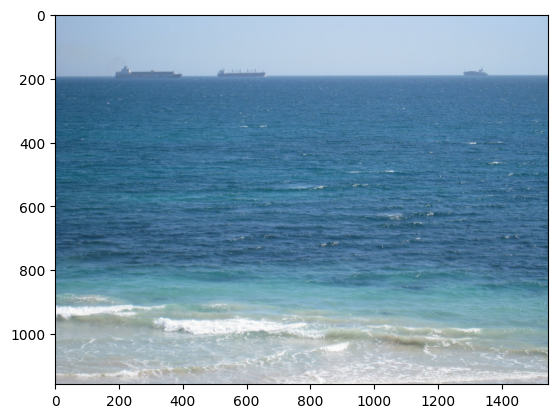

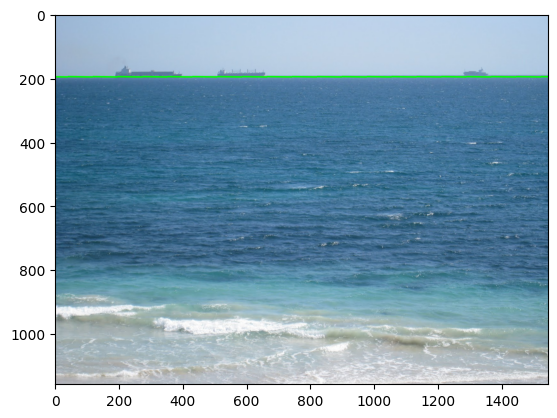

In [16]:
print(x_min, x_at_y_max)
cv2_imshow(cropped_image)
cv2_imshow(cropped_image_with_line)

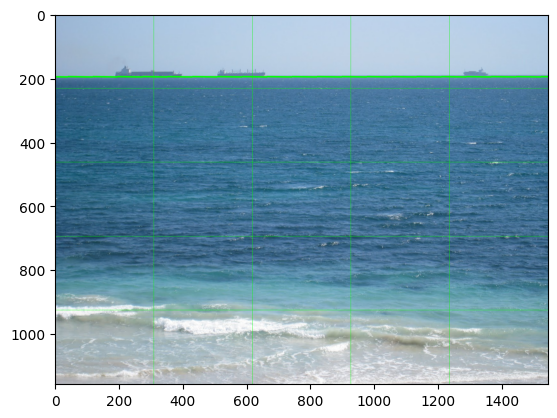

In [17]:
# view grid to check level
def draw_grid(img, grid_shape, color=(0, 255, 0), thickness=1):
    h, w, _ = img.shape
    rows, cols = grid_shape
    dy, dx = h / rows, w / cols

    # draw vertical lines
    for x in np.linspace(start=dx, stop=w - dx, num=cols - 1):
        x = int(round(x))
        cv2.line(img, (x, 0), (x, h), color=color, thickness=thickness)

    # draw horizontal lines
    for y in np.linspace(start=dy, stop=h - dy, num=rows - 1):
        y = int(round(y))
        cv2.line(img, (0, y), (w, y), color=color, thickness=thickness)

    return img


draw_grid(cropped_image_with_line, (5, 5))
cv2_imshow(cropped_image_with_line)

# Ship detection

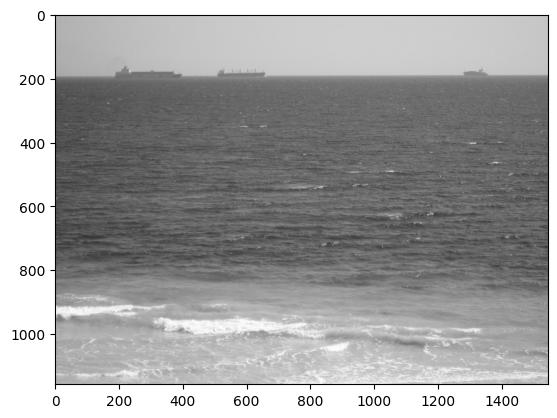

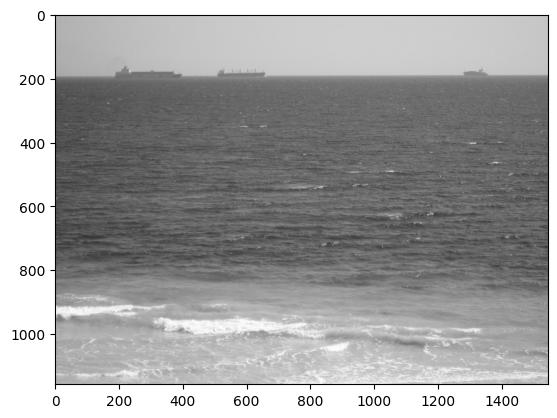

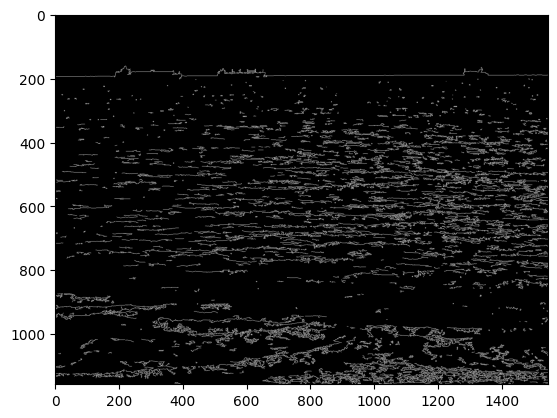

Found 294 lines


In [18]:
_, (x1, y1), (x2, y2) = detect_line(
    detect_edges(cropped_image), W=cropped_image.shape[1], H=cropped_image.shape[0]
)

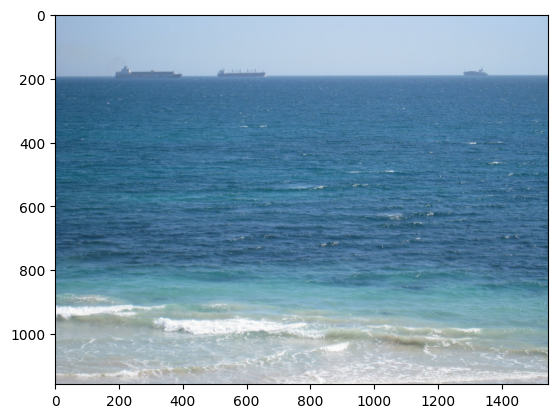

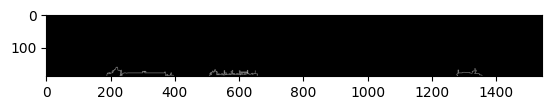

In [19]:
blur_img = cropped_image.copy()
cropped_image_upper = cropped_image[0:y1, :]
# cropped_image_upper = cropped_image[y1:, :]
gray = cv2.cvtColor(cropped_image_upper, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_TOZERO)
edges = cv2.Canny(thresh, 50, 150, apertureSize=3)
kernel_size = (5, 5)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
contours, hierarchy = cv2.findContours(
    closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

cv2_imshow(cropped_image)
cv2_imshow(edges)

508 170 151 20
1278 166 80 24
189 162 209 28


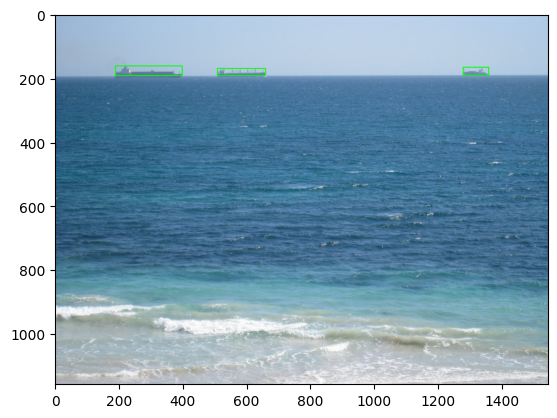

In [20]:
ship_detect = cropped_image.copy()
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)

    print(x, y, w, h)
    cv2.rectangle(ship_detect, (x, y), (x + w, y + h + 2), (0, 255, 0), 2)

cv2_imshow(ship_detect)